In [213]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
module_path = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(module_path)
import pandas as pd
import scipy.signal as ss
import sys

import tools.data_reader as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing

from scipy.fft import fft, fftfreq, fftshift


In [ ]:
#LOAD ECG DATA
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

convert_sr = False
task = dr.Tasks.BASELINE
data_type = dr.DataTypes.ECG
phase = dr.Phases.BASE_REST
fs = 250.0
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr)

data = la_ecg[0]
preprocessing.plot_1d_data(data[500:1000])

# ha_ecg = preprocessing.crop_list_of_ndarrays(ha_ecg)
# la_ecg = preprocessing.crop_list_of_ndarrays(la_ecg)
# freq, ha_ecg_fft = preprocessing.calculate_fft(ha_ecg, fs, f_dim)
# freq, la_ecg_fft = preprocessing.calculate_fft(la_ecg, fs, f_dim)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


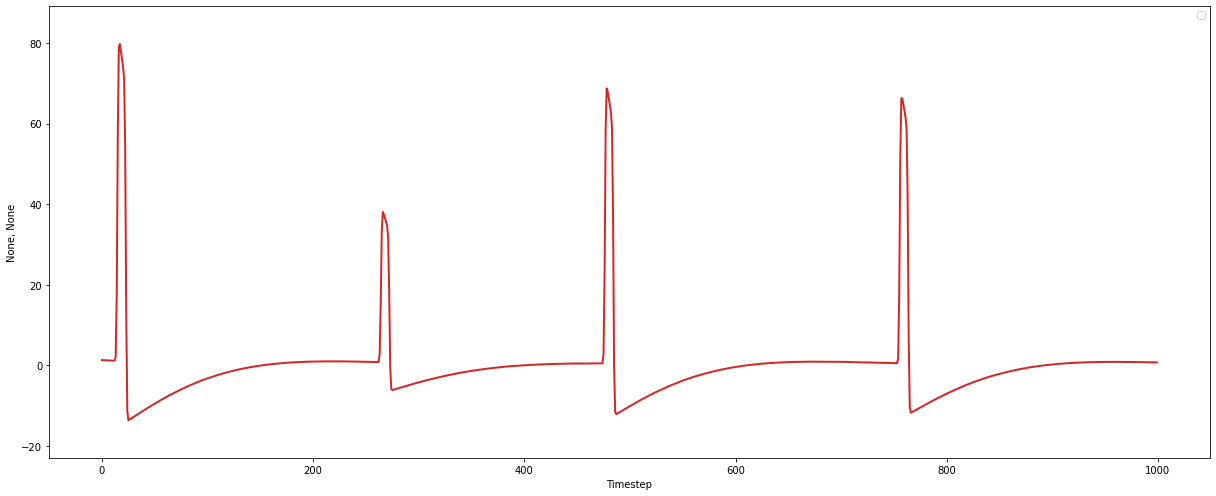

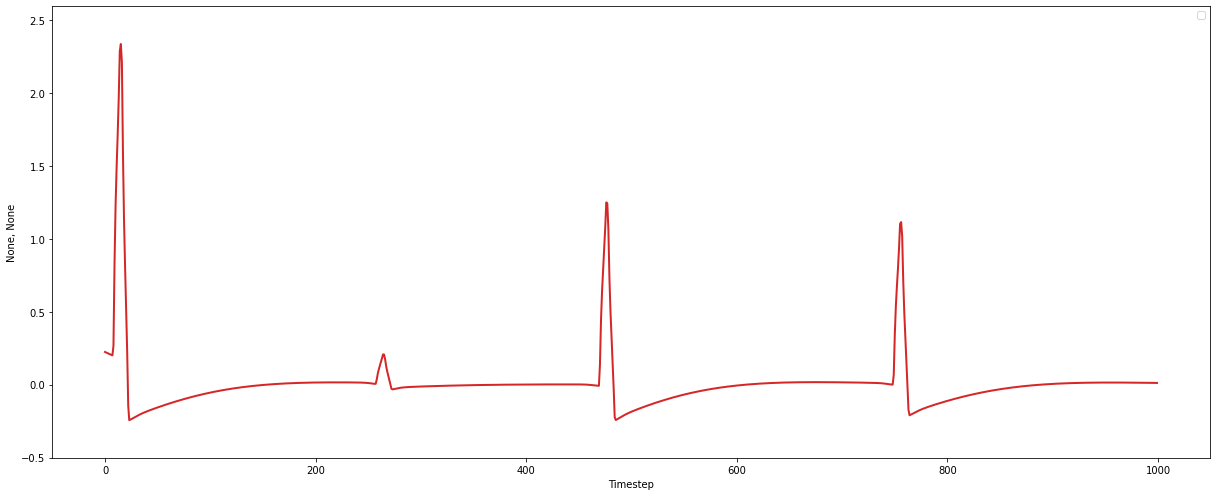

In [216]:
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

data = ha_ecg[4]
dt.plot_1d_data(data[10000:11000])

data = preprocessing.clean_ecg(data)
dt.plot_1d_data(data[10000:11000])


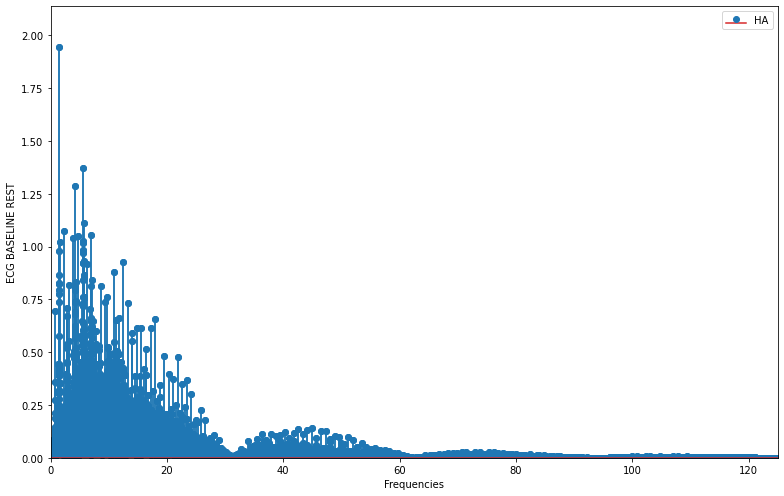

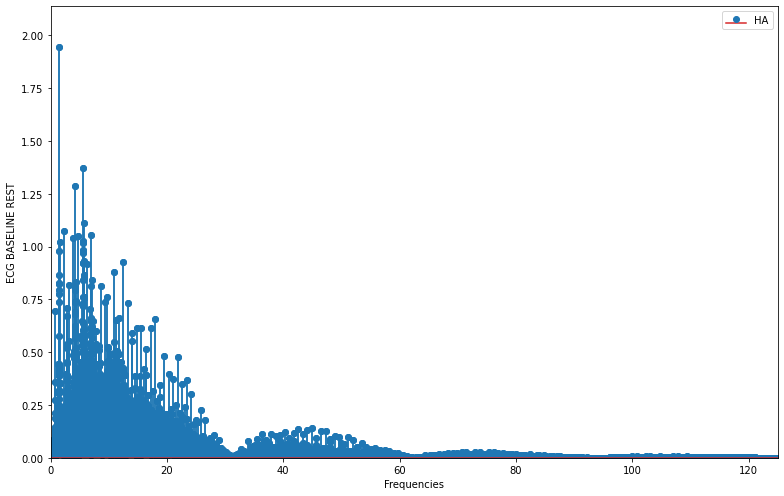

FROM BATCH CALCULATED FFT


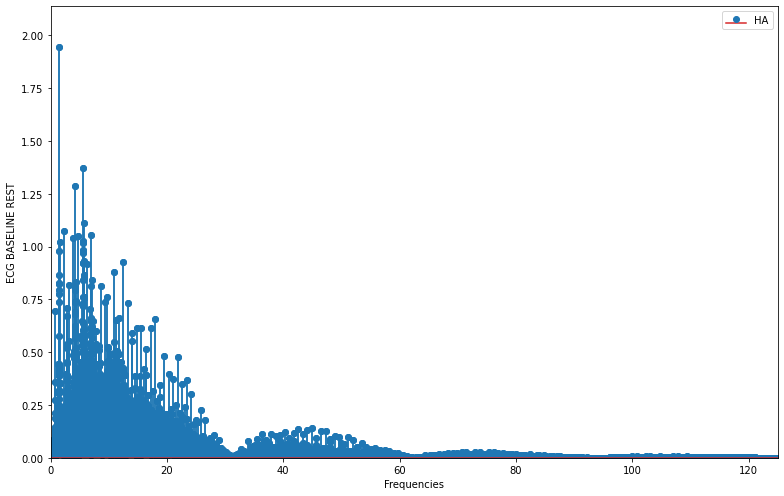

In [208]:
# EXAMPLES ON HOW TO PLOT FFT USING DIFFERENT METHODS (calculate_fft, calculate_fft_1d, calculate_group_metric)

importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

convert_sr = False
task = dr.Tasks.BASELINE
data_type = dr.DataTypes.ECG
phase = dr.Phases.BASE_REST
fs = 250.0
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr)
data = ha_ecg[0]
data = np.reshape(data, (data.size, 1))
freq, fft = preprocessing.calculate_fft(data, fs, feature_dim=f_dim)
dt.plot_fft_data(freq[1:], fft[0][1:], data_type="ECG BASELINE REST", labels="HA")


freq, fft = preprocessing.calculate_fft_1d(data, fs)
dt.plot_fft_data(freq[1:], fft[1:], data_type="ECG BASELINE REST", labels="HA")


print("FROM BATCH CALCULATED FFT")
freq, ha_ecg_fft = preprocessing.calculate_group_metric("HA", task, data_type, phase, "fft")
dt.plot_fft_data(freq[1:], ha_ecg_fft[1:, 0, 0], data_type="ECG BASELINE REST", labels="HA")



In [234]:
# FEATURE EXTRACTION WITH HEARTPY - BPM
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import heartpy as hp

convert_sr = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
data_type = dr.DataTypes.ECG
fs = 250.0
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr)
# freq, ha_ecg_fft = preprocessing.calculate_group_metric("HA", task, data_type, phase, "fft")
# freq, la_ecg_fft = preprocessing.calculate_group_metric("LA", task, data_type, phase, "fft")


for task in tasks:
    if task == dr.Tasks.BASELINE:
        phases = [dr.Phases.BASE_REST, dr.Phases.BASE_SPEECH]
    elif task == dr.Tasks.BUGS:
        phases = [dr.Phases.BUG_RELAX, dr.Phases.BUG_INSTRUCTIONS, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_DECISION, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK, dr.Phases.BUG_REFLECT]
    else:
        phases = [dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_INSTRUCTIONS, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_DECISION, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK, dr.Phases.SPEECH_REFLECT]
    for phase in phases:
        la = []
        ha = []
        print(f"LA {phase}")
        for i in range(len(la_ecg)):
            # print(f"Index {i}")
            data = la_ecg[i].flatten()
            working_data, measures = hp.process(data, fs)
            bpm = measures['bpm']
            while bpm > 130.0:
                # hp.plotter(working_data, measures, figsize=(17, 7), title=f"HR Peak Detection, LA @ index {i}")  
                print(f"\tInvalid BPM of {bpm} for LA at index {i}, reprocessing...")
                data = hp.filter_signal(data, cutoff=5, sample_rate=fs, order=3)
                # data = hp.enhance_ecg_peaks(data, fs)
                try:
                    working_data, measures = hp.process(data, fs, calc_freq=True, freq_method="fft")
                except Exception as e:
                    print(f"Error with LA index {i}: {e}")
                bpm = measures['bpm']
            la.append(bpm)
            # print(f"\tBPM: {bpm}")

        print(f"HA {phase}")
        for i in range(len(ha_ecg)):
            # print(f"Index {i}")
            data = ha_ecg[i].flatten()
            working_data, measures = hp.process(data, fs)
            bpm = measures['bpm']
            while bpm > 130.0:
                # hp.plotter(working_data, measures, figsize=(17, 7), title=f"HR Peak Detection, HA @ index {i}")  
                print(f"\tInvalid BPM of {bpm} for HA at index {i}, reprocessing...")
                data = hp.filter_signal(data, cutoff=5, sample_rate=fs, order=3)
                # data = hp.enhance_ecg_peaks(data, fs)
                try:
                    working_data, measures = hp.process(data, fs, calc_freq=True, freq_method="fft")
                except Exception as e:
                    print(f"Error with HA index {i}: {e}")
                bpm = measures['bpm']
            ha.append(bpm)
            # print(f"\tBPM: {bpm}")

        bpm_array = np.array([la, ha]).transpose()
        bpm_df = pd.DataFrame(bpm_array, columns=["LA", "HA"])

        bpm_file = os.path.join(dr.Paths.METRICS, f"bpm_{phase}.csv")
        with open(bpm_file, "w+") as f:
            bpm_df.to_csv(f)


LA Baseline_Rest
	Invalid BPM of 233.3804809052334 for LA at index 8, reprocessing...


c:\Users\zhoux\AppData\Local\Programs\Python\Python38\lib\site-packages\heartpy\analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)


	Invalid BPM of 162.14484084597308 for LA at index 14, reprocessing...
	Invalid BPM of 149.97020459511356 for LA at index 14, reprocessing...
	Invalid BPM of 134.6354073169856 for LA at index 14, reprocessing...
HA Baseline_Rest
	Invalid BPM of 137.21614415739634 for HA at index 9, reprocessing...
	Invalid BPM of 143.92390805556715 for HA at index 9, reprocessing...
	Invalid BPM of 142.21783980582526 for HA at index 15, reprocessing...
	Invalid BPM of 165.12930324493493 for HA at index 15, reprocessing...
	Invalid BPM of 161.19729212835068 for HA at index 15, reprocessing...
	Invalid BPM of 156.3954570843418 for HA at index 15, reprocessing...
	Invalid BPM of 172.72364217252397 for HA at index 20, reprocessing...
LA Baseline_Speech
	Invalid BPM of 233.3804809052334 for LA at index 8, reprocessing...
	Invalid BPM of 162.14484084597308 for LA at index 14, reprocessing...
	Invalid BPM of 149.97020459511356 for LA at index 14, reprocessing...
	Invalid BPM of 134.6354073169856 for LA at ind

In [ ]:
# FEATURE EXTRACTION WITH HEARTPY
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import heartpy as hp

convert_sr = False
task = dr.Tasks.BASELINE
data_type = dr.DataTypes.ECG
phase = dr.Phases.BASE_REST
fs = 250.0
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr)

# data = la_ecg[0]
# working_data, measures = hp.process(data, fs)
# bpm = measures['bpm']
# print(f"BPM: {bpm}")
# dt.plot_1d_data(data[0:10000])

data = la_ecg[8]
dt.plot_1d_data(data)
data = hp.filter_signal(data, cutoff=5, sample_rate=fs, order=3)
dt.plot_1d_data(data)
working_data, measures = hp.process(data, fs)
bpm = measures['bpm']
print(f"BPM: {bpm}")
dt.plot_1d_data(data[0:10000])